In [ ]:
from pyiron_workflow_atomistics.bulk import eos_volume_scan, get_equil_lat_param, get_bulk_structure

from tensorpotential.calculator import TPCalculator

from ase.build import bulk

from gb_constructor import get_gbstruct_from_gbcode, construct_GB_from_GBCode
from gb_optimiser_v20250507 import gb_length_optimiser

# from gb_optimiser_v20250506 import gb_length_optimiser
import numpy as np

from pyiron_workflow import Workflow
from pyiron_workflow.api import for_node
from pyiron_workflow_atomistics.calculator import calculate_structure_node
from pyiron_workflow_atomistics.gb.gb_constructor import construct_GB_from_GBCode

import pyiron_workflow as pwf
%load_ext autoreload
%autoreload 2

2025-05-27 01:04:16.904379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-27 01:04:16.990282: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-27 01:04:16.990422: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-27 01:04:17.036291: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


I0000 00:00:1748268693.546357   12187 service.cc:145] XLA service 0x55efc6353eb0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748268693.546400   12187 service.cc:153]   StreamExecutor device (0): Host, Default Version
2025-05-26 16:11:33.743879: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748268696.707528   12187 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/cmmc/ptmp/hmai/mambaforge/envs/pyiron_workflow/lib/python3.12/site-packages/pymatgen/io/vasp/inputs.py:435: BadPoscarWarning: Elements in POSCAR cannot be determined. Defaulting to false names ['H', 'H', 'H', 'H', 'H', 'H', 'He', 'He', 'He', 'He', 'He', 'He'].
  warnings.warn(
/cmmc/ptmp/hmai/mambaforge/envs/pyiron_workflow/lib/python3.12/site-packages/pymatgen/io/vasp/inputs.py:43

0
      Step     Time          Energy          fmax
BFGS:    0 16:11:42     -295.775416        0.673971
BFGS:    1 16:11:42     -295.803325        0.530631
BFGS:    2 16:11:42     -295.863286        0.195338
BFGS:    3 16:11:43     -295.868074        0.167009
BFGS:    4 16:11:43     -295.881359        0.160630
BFGS:    5 16:11:43     -295.888550        0.125137
BFGS:    6 16:11:43     -295.892508        0.077747
BFGS:    7 16:11:43     -295.894401        0.068585
BFGS:    8 16:11:43     -295.896514        0.085152
BFGS:    9 16:11:43     -295.899034        0.094132
BFGS:   10 16:11:44     -295.901162        0.064710
BFGS:   11 16:11:44     -295.902408        0.045067
BFGS:   12 16:11:44     -295.903294        0.045780
BFGS:   13 16:11:44     -295.904132        0.038380
BFGS:   14 16:11:44     -295.904728        0.029822
BFGS:   15 16:11:44     -295.904975        0.017909
BFGS:   16 16:11:44     -295.905069        0.016649
BFGS:   17 16:11:45     -295.905160        0.014475
BFGS:   18 1

{'eos__B': 1.0888794134964814,
 'eos__volumes': [21.332292682904004,
  21.594572051010047,
  21.858992463340865,
  22.12556262332826,
  22.39429123440404,
  22.665187000000007,
  22.938258623547974,
  23.21351480847975,
  23.490964258227127,
  23.770615676221958,
  24.052477765896],
 'eos__energies': [-16.426852917139826,
  -16.445540896964737,
  -16.45924258740174,
  -16.468383524321588,
  -16.473368947210723,
  -16.474570704126037,
  -16.472319307811315,
  -16.46690065609176,
  -16.458556567783948,
  -16.447488114746896,
  -16.43386071411896],
 'gb_structure__original_GBcode_structure': MSONAtoms(symbols='Fe36', pbc=True, cell=[41.56525746, 2.44925628, 3.99961876]),
 'gb_length_optimiser__stage1_opt_struct': MSONAtoms(symbols='Fe36', pbc=True, cell=[2.44925628, 3.99961876, 41.87218287390869]),
 'gb_length_optimiser__stage1_opt_excvol': 0.153462645966363,
 'gb_length_optimiser__stage1_opt_GBEnergy': -295.95458300619384,
 'gb_length_optimiser__stage2_opt_struct': NOT_DATA,
 'gb_length_

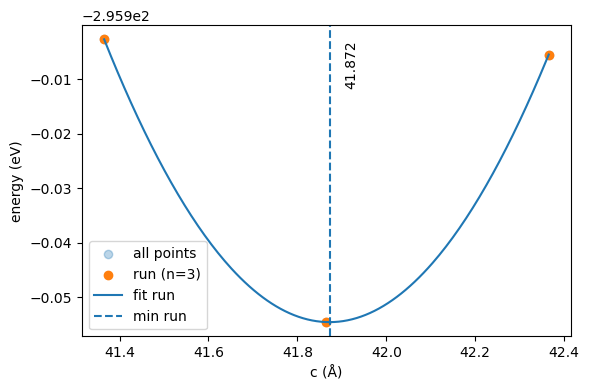

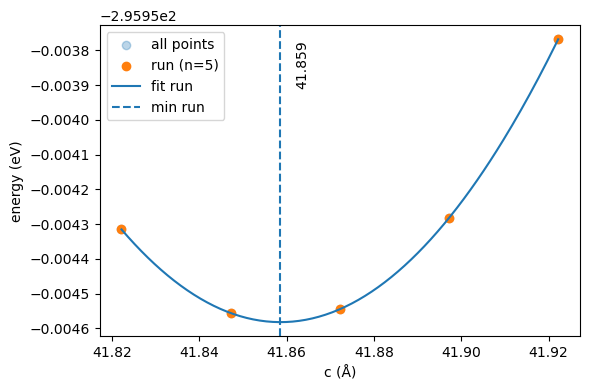

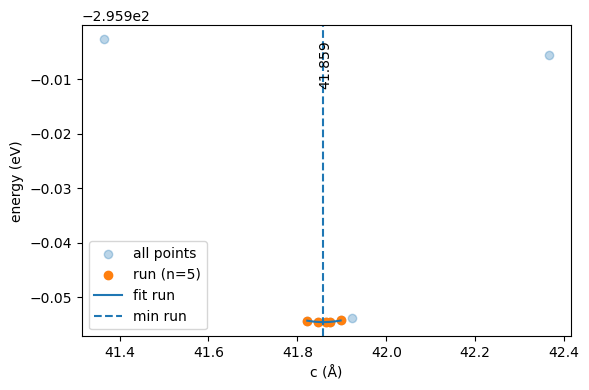

In [2]:
# 1. Prepare calculator and workflow
calc = TPCalculator("2025_04_29_FeGB_Segregation_Workflows/final_model/")
wf   = Workflow("gb_optimiser_whole", delete_existing_savefiles=True)

# 2. Build your base Fe structure
bulk_Fe = bulk("Fe", cubic=True, a=2.83)
bulk_Fe.rattle()

# 3. Attach the macro node to the workflow, capturing all outputs
wf.eos = eos_volume_scan(
    base_structure = bulk_Fe,
    calc           = calc,
    calc_kwargs = {"fmax": 0.01,
                   "max_steps": 10000,
                   "properties": ("energy", "forces", "stresses", "volume"),
                   "write_to_disk": True,
                   "output_dir": "gb_optimiser_whole/EOS"},
    axes           = ["x", "y", "z"],
    strain_range   = (-0.02, 0.02),
    num_points     = 11,

)
wf.a0 = get_equil_lat_param(wf.eos.outputs.v0)
wf.eq_bulk_struct = get_bulk_structure(name = "Fe",
                           cubic = True,
                           a = wf.a0)
@pwf.as_function_node("equil_volume_peratom")
def get_per_atom_equil_vol(total_volume, structure):
    per_atom_equil_vol = total_volume/len(structure)
    return per_atom_equil_vol

@pwf.as_function_node("equil_energy_peratom")
def get_per_atom_equil_energy(total_energy, structure):
    per_atom_equil_energy = total_energy/len(structure)
    return per_atom_equil_energy
    
wf.equil_energy = get_per_atom_equil_vol(wf.eos.outputs.e0, wf.eq_bulk_struct.outputs.equil_struct)
wf.equil_volume = get_per_atom_equil_vol(wf.eos.outputs.v0, wf.eq_bulk_struct.outputs.equil_struct)
wf.gb_structure = construct_GB_from_GBCode(
    axis=(1, 1, 1),
    basis="bcc",
    lattice_param=wf.a0,
    m=3,
    n=1,
    GB1=(-1, -1, 2),
    element="Fe",
    req_length_grain=15,
    grain_length_axis=0,
    arrange_ab_by_length=True,
    perform_equiv_check=False,
    merge_dist_tolerance=1.3,
    merge_mode="average",
    equil_volume=wf.equil_volume
)
from gb_optimiser_v20250507 import full_gb_length_optimization
wf.gb_length_optimiser = full_gb_length_optimization(
    gb_structure=wf.gb_structure.outputs.final_structure,
    calc=calc,
    calc_kwargs={
        "fmax": 0.01,
        "max_steps": 500,
        "properties": ("energy", "forces", "stresses", "volume"),
        "write_to_disk": False,
        "output_dir": "gb_optimiser_whole/GB_length_opt"
    },
    equil_bulk_volume=wf.equil_volume,
    equil_bulk_energy=wf.equil_energy,
    extensions_stage1=np.linspace(-0.2, 0.8, 3),
    extensions_stage2=np.linspace(-0.05, 0.05, 5),
    interpolate_min_n_points=5,
    gb_normal_axis="c"
)

from pyiron_workflow_atomistics.structure_manipulator.tools import add_vacuum
wf.gb_with_vacuum = add_vacuum(wf.gb_length_optimiser.outputs.gb_structure_final,
                               vacuum_length = 20,
                               axis = "c")
wf.gb_with_vacuum_rel =  calculate_structure_node(
                                        structure = wf.gb_with_vacuum,
                                        calc = calc,
                                        fmax = 0.01,
                                        max_steps = 10000,
                                        properties = ('energy', 'forces', 'stresses'),
                                        write_to_disk = False,
                                        output_dir = "gb_optimiser_whole/GB_rel_vacuum",
                                        initial_struct_path = 'initial_structure.xyz',
                                        initial_results_path = 'initial_results.json',
                                        traj_struct_path = 'trajectory.xyz',
                                        traj_results_path = 'trajectory_results.json',
                                        final_struct_path = 'final_structure.xyz',
                                        final_results_path = 'final_results.json'
                                        )
from pyiron_workflow_atomistics.structure_manipulator.tools import add_vacuum, create_supercell_with_min_dimensions

wf.gb_seg_supercell = create_supercell_with_min_dimensions(wf.gb_with_vacuum_rel.outputs.atoms, 
                                                           min_dimensions=[6, 6, None])

wf.run()

In [8]:
from ase.io import read

# Read all frames from a LAMMPS dump file
all_atoms = read('demo_pyiron_lammps//dump.out', index=':' , format='lammps-dump-text')

# Or read a single snapshot (e.g. frame 0)
# atoms0 = read('traj.lammpstrj', index=0, format='lammps-dump')

print(f"Total frames: {len(all_atoms)}")
print(all_atoms[0])


Total frames: 2
Atoms(symbols='H1000', pbc=True, cell=[[24.508518927099615, 0.0, 0.0], [-8.169506309033205, 23.106853240254644, 0.0], [-8.169506309033205, -11.553426620127324, 20.011121907579295]], momenta=..., calculator=SinglePointCalculator(...))


In [10]:
all_atoms[0].arrays["momenta"]

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.],
       ...,
       [0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [12]:
output.keys()

dict_keys(['generic', 'lammps'])

In [14]:
output["lammps"]

{}

In [11]:
output = parse_lammps_output_files(
    working_directory=working_directory,
    structure=structure,
    potential_elements=potential_elements,
    units="metal",
    dump_h5_file_name="dump.h5",
    dump_out_file_name="dump.out",
    log_lammps_file_name="log.lammps",
)


/cmmc/ptmp/hmai/mambaforge/envs/pyiron_workflow/lib/python3.12/site-packages/pyiron_lammps/output.py:133: UserWarning: LAMMPS warning: No log.lammps output file found.
  warnings.warn("LAMMPS warning: No log.lammps output file found.")


{'generic': {'steps': array([ 0, 21]),
  'natoms': array([1000., 1000.]),
  'cells': array([[[ 2.45085189e+01,  1.50071396e-15,  1.50071396e-15],
          [-8.16950631e+00,  2.31068532e+01,  9.14648705e-16],
          [-8.16950631e+00, -1.15534266e+01,  2.00111219e+01]],
  
         [[ 2.45085189e+01,  1.50071396e-15,  1.50071396e-15],
          [-8.16950631e+00,  2.31068532e+01,  9.14648705e-16],
          [-8.16950631e+00, -1.15534266e+01,  2.00111219e+01]]]),
  'indices': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]),
  'forces': array([[[ 6.05624307e-01, -9.25885637e-01, -3.88041295e-01],
          [ 1.28461854e+00, -1.67978861e+00, -8.01751275e-01],
          [ 3.13767780e-01,  4.17917636e-01, -1.44622694e+00],
          ...,
          [ 8.18888008e-02, -5.56977604e-02, -8.27958416e-01],
          [-8.07868417e-01,  6.53772238e-01,  5.75985756e-01],
          [-2.59939283e-01,  1.74402345e+00,  7.69636356e-01]],
  
         [[ 4.18771859e-05, -2.58047423e-04,

In [44]:
#LAMMPS executable.

import os
import subprocess

from ase.build import bulk
from pyiron_lammps import parse_lammps_output_files, write_lammps_structure

lammps_input_script = """\
units metal
dimension 3
boundary p p p
atom_style atomic

read_data lammps_with_masses.data

pair_style grace
pair_coeff * * /cmmc/u/hmai/2025_04_29_FeGB_Segregation_Workflows/4_GPU_run1/seed/1/saved_model/ Fe

# per‐atom potential energy
compute eng all pe/atom

# dump every 10 steps: coords, forces, velocities, AND per‐atom energy
dump 1 all custom 10 dump.out id type xsu ysu zsu fx fy fz vx vy vz c_eng
dump_modify 1 sort id format line "%d %d %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g %20.15g"

# global thermo output to log
thermo_style custom step temp pe etotal pxx pxy pxz pyy pyz pzz vol
thermo_modify format float %20.15g
thermo 10

min_style   cg
minimize    0 0.01 1000000 1000000
"""
from ase.io.lammpsdata import read_lammps_data, write_lammps_data
from pymatgen.core import Structure
from pymatgen.io.lammps.data import LammpsData
from pymatgen.io.ase import AseAtomsAdaptor


atoms = bulk("Fe") * [10,10,10]
atoms.rattle(0.3)
structure = AseAtomsAdaptor.get_structure(atoms)
lammps_data = LammpsData.from_structure(
    structure,
    atom_style="atomic",
)
os.makedirs(working_directory, exist_ok=True)
lammps_data.write_file("demo_pyiron_lammps/lammps_with_masses.data")
# 2) Assign chemical symbols so ASE knows which mass to use
#    Here all atoms are Fe:
atoms.set_chemical_symbols(['Fe'] * len(atoms))
# 3) Write out a new data file, sorted by type, with a Masses section
potential_elements = ["Fe"]
with open(os.path.join(working_directory, "lmp.in"), "w") as f:
    f.writelines(lammps_input_script)

command = "mpirun -np 40 --bind-to none /cmmc/ptmp/hmai/LAMMPS/lammps_grace/build/lmp -in lmp.in -log minimize.log"

output = subprocess.check_output(
    command,
    cwd=working_directory,
    shell=True,
    universal_newlines=True,
    env=os.environ.copy(),
)

output = parse_lammps_output_files(
    working_directory=working_directory,
    structure=atoms,
    potential_elements=potential_elements,
    units="metal",
    dump_h5_file_name="dump.h5",
    dump_out_file_name="dump.out",
    log_lammps_file_name="minimize.log",
)
output

2025-05-26 19:47:53.030543: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 19:47:53.030532: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 19:47:53.030551: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 19:47:53.035677: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machi

{'generic': {'eng': array([[-6.75575207, -6.72316516, -7.54244379, ..., -7.72358715,
          -7.61678979, -7.45744122],
         [-8.11920554, -8.14203334, -8.14581791, ..., -8.14692011,
          -8.14301978, -8.22608757],
         [-8.23136612, -8.22559122, -8.22854639, ..., -8.22281797,
          -8.23045368, -8.23411899],
         ...,
         [-8.22675499, -8.22704935, -8.22646648, ..., -8.22651629,
          -8.22698464, -8.22716539],
         [-8.22675528, -8.22705034, -8.22646711, ..., -8.22651417,
          -8.22698411, -8.22716571],
         [-8.22675747, -8.22705574, -8.22647044, ..., -8.22650307,
          -8.22698135, -8.22716716]]),
  'steps': array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
         130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
         260]),
  'natoms': array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000.,

In [45]:
output

{'generic': {'eng': array([[-6.75575207, -6.72316516, -7.54244379, ..., -7.72358715,
          -7.61678979, -7.45744122],
         [-8.11920554, -8.14203334, -8.14581791, ..., -8.14692011,
          -8.14301978, -8.22608757],
         [-8.23136612, -8.22559122, -8.22854639, ..., -8.22281797,
          -8.23045368, -8.23411899],
         ...,
         [-8.22675499, -8.22704935, -8.22646648, ..., -8.22651629,
          -8.22698464, -8.22716539],
         [-8.22675528, -8.22705034, -8.22646711, ..., -8.22651417,
          -8.22698411, -8.22716571],
         [-8.22675747, -8.22705574, -8.22647044, ..., -8.22650307,
          -8.22698135, -8.22716716]]),
  'steps': array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
         130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
         260]),
  'natoms': array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
         1000.,

In [29]:
from ase.io.lammpsdata import read_lammps_data, write_lammps_data

# 1) Read your data file (this gives you types but no symbols)
# atoms = read_lammps_data(
#     filename='lammps.data',
#     style='atomic'
# )

# 2) Assign chemical symbols so ASE knows which mass to use
#    Here all atoms are Fe:
atoms.set_chemical_symbols(['Fe'] * len(atoms))

# 3) Write out a new data file, sorted by type, with a Masses section
write_lammps_data(
    file     = 'lammps_with_masses.data',
    atoms         = atoms,
    atom_style    = 'atomic',
    # sort_by_type  = True
)


In [28]:
atoms

Atoms(symbols='Fe1000', pbc=True, cell=[[-14.350000000000001, 14.350000000000001, 14.350000000000001], [14.350000000000001, -14.350000000000001, 14.350000000000001], [14.350000000000001, 14.350000000000001, -14.350000000000001]], initial_magmoms=...)

In [31]:
from pymatgen.io import lammps